<a href="https://colab.research.google.com/github/Shreshta001/MiniProjectMultimodalTransformerSARS/blob/main/latent_extraction_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/bdd100k/val/annotations/bdd100k_labels_images_val.json
/kaggle/input/bdd100k/val/images/b5764fb7-c47fa3ec.jpg
/kaggle/input/bdd100k/val/images/b539383c-b57307bc.jpg
/kaggle/input/bdd100k/val/images/c0a7a9dc-497459f0.jpg
/kaggle/input/bdd100k/val/images/c4a19ba6-e706bdc2.jpg
/kaggle/input/bdd100k/val/images/c0e6d0ec-17a4eb38.jpg
/kaggle/input/bdd100k/val/images/b5e1a441-3bc3277c.jpg
/kaggle/input/bdd100k/val/images/b5191523-af1c9a30.jpg
/kaggle/input/bdd100k/val/images/bfc06497-fc2b4581.jpg
/kaggle/input/bdd100k/val/images/b82f91d7-808670c6.jpg
/kaggle/input/bdd100k/val/images/c9dc96aa-01dec7af.jpg
/kaggle/input/bdd100k/val/images/c7eab2ff-29602d7b.jpg
/kaggle/input/bdd100k/val/images/be46639a-25990c25.jpg
/kaggle/input/bdd100k/val/images/b1ee702d-0ae1fc10.jpg
/kaggle/input/bdd100k/val/images/c92aeef7-c8f9fb98.jpg
/kaggle/input/bdd100k/val/images/c6a4abc9-8897c0c0.jpg
/kaggle/input/bdd100k/val/images/b52e3ad8-aebd0e55.jpg
/kaggle/input/bdd100k/val/images/bafeadd4-255dc46e.

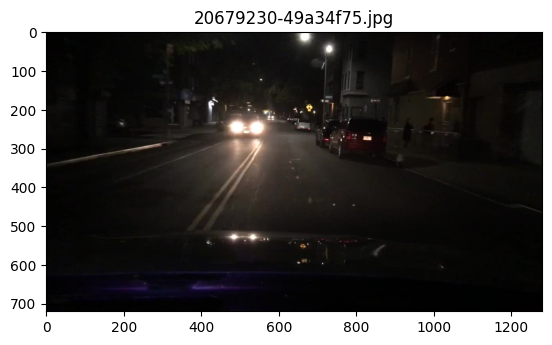

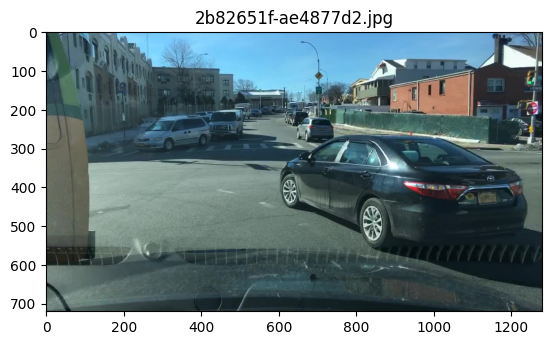

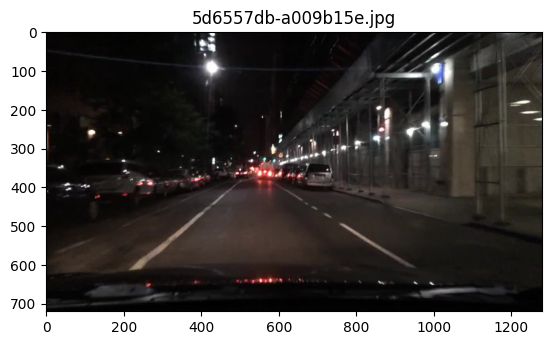

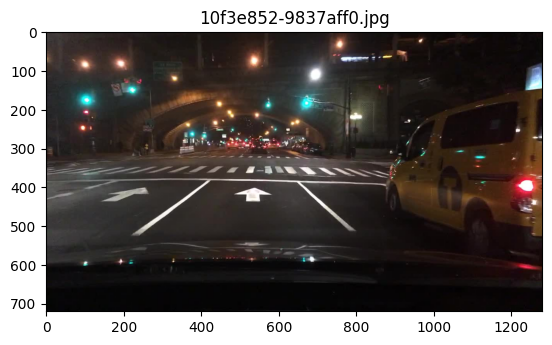

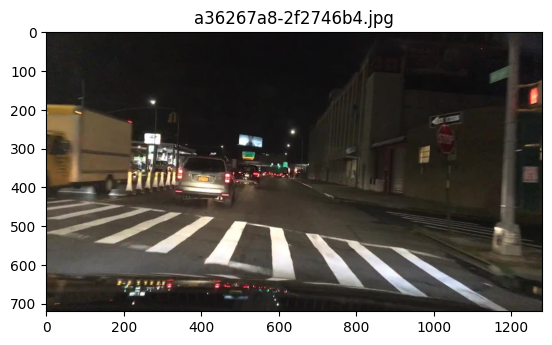

In [ ]:
import os
import matplotlib.pyplot as plt

image_dir = '/kaggle/input/bdd100k/train/images'

# Get a list of image files
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]

# Display the first few images
for i in range(5):
    image_path = os.path.join(image_dir, image_files[i])
    img = plt.imread(image_path)
    plt.imshow(img)
    plt.title(image_files[i])
    plt.show()

In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoProcessor
import pandas as pd
from PIL import Image
import random


model_name = "google/vit-base-patch16-224-in21k"

# Load the processor for ViT
processor = AutoProcessor.from_pretrained(model_name)


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [ ]:
import os
import pandas as pd
import random
from PIL import Image
from torch.utils.data import Dataset

# Step 1: Generate random image pairs and distances
image_dir = '/kaggle/input/bdd100k/train/images'

# List all image files
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]

# Number of random pairs you want to generate
num_pairs = 100

# Create random pairs and random distances
data = []
for _ in range(num_pairs):
    img1, img2 = random.sample(image_files, 2)
    distance = random.uniform(0, 1)
    data.append([img1, img2, distance])

# Create a DataFrame
df = pd.DataFrame(data, columns=['image_1', 'image_2', 'distance'])

# Save to CSV
csv_file_path = '/kaggle/working/random_image_pairs_with_distance.csv'  # Path to save the CSV file
df.to_csv(csv_file_path, index=False)

print("CSV file created successfully with random image pairs and distances!")

# Step 2: Define the ImagePairDataset class
class ImagePairDataset(Dataset):
    def __init__(self, csv_file, image_dir, processor):
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.processor = processor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img1_path = os.path.join(self.image_dir, row['image_1'])
        img2_path = os.path.join(self.image_dir, row['image_2'])
        distance = torch.tensor(row['distance'], dtype=torch.float32)

        # Open images
        img1 = Image.open(img1_path).convert("RGB")
        img2 = Image.open(img2_path).convert("RGB")

        # Process images
        inputs1 = self.processor(images=img1, return_tensors="pt")
        inputs2 = self.processor(images=img2, return_tensors="pt")

        # Return processed tensors and the distance
        return {
            "input_ids_1": inputs1["pixel_values"].squeeze(),
            "input_ids_2": inputs2["pixel_values"].squeeze(),
            "distance": distance
        }


#
from transformers import AutoProcessor

model_name = "google/vit-base-patch16-224-in21k"
processor = AutoProcessor.from_pretrained(model_name)


dataset = ImagePairDataset(csv_file_path, image_dir, processor)

from torch.utils.data import DataLoader

dataloader = DataLoader(dataset, batch_size=8, shuffle=True)  # Adjust batch_size as needed



CSV file created successfully with random image pairs and distances!


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [ ]:
import torch
from torch import nn
from transformers import AutoModel

class ViTDistanceModel(nn.Module):
    def __init__(self, model_name):
        super(ViTDistanceModel, self).__init__()
        # Load the ViT model
        self.vit = AutoModel.from_pretrained(model_name)
        # Define a head to output a single distance value
        self.fc = nn.Linear(self.vit.config.hidden_size * 2, 1)  # Times 2 for concatenation of embeddings

    def forward(self, input_ids_1, input_ids_2):
        # Pass both images through the model
        outputs1 = self.vit(input_ids_1).last_hidden_state[:, 0]
        outputs2 = self.vit(input_ids_2).last_hidden_state[:, 0]

        # Concatenate the representations and pass through a fully connected layer
        concatenated = torch.cat((outputs1, outputs2), dim=1)  # [batch_size, hidden_size * 2]
        distance = self.fc(concatenated)  # [batch_size, 1]
        return distance.squeeze()  # [batch_size]


In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import pandas as pd
from PIL import Image
from torchvision import transforms

# Define your ImagePairDataset class (ensure it processes images correctly)
class ImagePairDataset(Dataset):
    def __init__(self, csv_file, image_dir, processor):
        self.data = pd.read_csv(csv_file)  # Read the CSV file
        self.image_dir = image_dir
        self.processor = processor  # ViT processor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img1_file = self.data.iloc[idx]["image_1"]
        img2_file = self.data.iloc[idx]["image_2"]
        distance = self.data.iloc[idx]["distance"]


        img1 = Image.open(os.path.join(self.image_dir, img1_file)).convert("RGB")
        img2 = Image.open(os.path.join(self.image_dir, img2_file)).convert("RGB")

        # Preprocess images using the processor
        inputs = self.processor(images=[img1, img2], return_tensors="pt", padding=True, truncation=True)

        return {
            "input_ids_1": inputs["pixel_values"][0],
            "input_ids_2": inputs["pixel_values"][1],
            "distance": torch.tensor(distance, dtype=torch.float32)  # Distance as a tensor
        }


image_dir = '/kaggle/input/bdd100k/train/images'  # Directory containing images
csv_file = '/kaggle/working/random_image_pairs_with_distance.csv'  # Your CSV file path


dataset = ImagePairDataset(csv_file, image_dir, processor)

# Creating a DataLoader
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViTDistanceModel(model_name).to(device)

# Define loss and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training parameters
epochs = 10

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for batch in dataloader:
        # Move data to device
        input_ids_1 = batch["input_ids_1"].to(device)
        input_ids_2 = batch["input_ids_2"].to(device)
        distances = batch["distance"].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_ids_1, input_ids_2)
        loss = criterion(outputs, distances)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print average loss for the epoch
    avg_loss = running_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")


/opt/conda/lib/python3.10/site-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
  return self.preprocess(images, **kwargs)


Epoch [1/10], Loss: 0.1260
Epoch [2/10], Loss: 0.0637
Epoch [3/10], Loss: 0.0323
Epoch [4/10], Loss: 0.0163
Epoch [5/10], Loss: 0.0089
Epoch [6/10], Loss: 0.0091
Epoch [7/10], Loss: 0.0080
Epoch [8/10], Loss: 0.0091
Epoch [9/10], Loss: 0.0044
Epoch [10/10], Loss: 0.0035
